In [1]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

In [2]:
from torch.utils.data import Dataset

class AutosDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, index):
    X = torch.Tensor(self.X[index])
    y = torch.Tensor(self.y[index])
    
    return X, y

  def __len__(self):
    return len(self.X)

In [3]:
import pandas as pd
dataset = pd.read_csv('autos.csv')
dataset[['bore', 'stroke', 'compression.ratio', 'horsepower', 'peak.rpm', 'city.mpg', 'highway.mpg', 'price']]

,bore,stroke,compression.ratio,horsepower,peak.rpm,city.mpg,highway.mpg,price
0,3.47,2.68,9.0,111,5000,21,27,13495
1,3.47,2.68,9.0,111,5000,21,27,16500
2,2.68,3.47,9.0,154,5000,19,26,16500
3,3.19,3.40,10.0,102,5500,24,30,13950
4,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...
188,3.78,3.15,9.5,114,5400,23,28,16845
189,3.78,3.15,8.7,160,5300,19,25,19045
190,3.58,2.87,8.8,134,5500,18,23,21485
191,3.01,3.40,23.0,106,4800,26,27,22470


In [4]:
X = dataset[dataset.columns[16:23]].values
y = dataset.price.values

from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(np.expand_dims(y,axis=1))

In [7]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.2)

from torch.utils.data import DataLoader

train_ds = AutosDataset(train_X, train_y)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)

valid_ds = AutosDataset(valid_X, valid_y)
valid_loader = DataLoader(valid_ds, batch_size=16, shuffle=False, num_workers=0)

test_ds = AutosDataset(test_X, test_y)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=0)


In [8]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7, 100)
        self.bn1 = nn.BatchNorm1d(100)
        
        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        
        self.fc3 = nn.Linear(100, 1)

    def forward(self, X):
        X = self.fc1(X)
        X = F.relu(X)
        X = self.bn1(X)
        X = self.fc2(X)
        X = F.relu(X)
        X = self.bn2(X)
        X = self.fc3(X)

        return X

In [9]:
net = Net()

criterion = nn.MSELoss()

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [10]:
epochs = 300
 
train_mean_losses = []
valid_mean_losses = []

valid_best_loss = np.inf

for i in range(epochs):    
    train_losses = []
    valid_losses = []
    
    print("==============================================================")
    print("Epoch {}".format(i))
    
    for iteration, batch_data in enumerate(train_loader):
        X_batch, y_batch = batch_data
        
        optimizer.zero_grad()
        
        out = net(X_batch)
        loss = criterion(out, y_batch.squeeze())
        
        loss.backward()
        optimizer.step()
        
#         print(f'training iteration: {iteration:3} loss: {loss:10.8f}')
        train_losses.append(loss)
    
    train_mean_loss = torch.mean(torch.stack(train_losses))
    print('training loss: {:10.8f}'.format(train_mean_loss))
    
    train_mean_losses.append(train_mean_loss)
        
    with torch.set_grad_enabled(False):
        for iteration, batch_data in enumerate(valid_loader):
            X_batch, y_batch = batch_data

            out = net(X_batch)
            loss = criterion(out, y_batch.squeeze())
            valid_losses.append(loss)
            
        valid_mean_loss = torch.mean(torch.stack(valid_losses))
        print('validation loss: {:10.8f}'.format(valid_mean_loss))
        
        valid_mean_losses.append(valid_mean_loss)
        
        if valid_mean_loss.cpu().numpy()[()] < valid_best_loss:
            valid_best_loss = valid_mean_loss
            torch.save(net.state_dict(), "best_model.pth")
            

Epoch 0


C:\Users\BN000275553\AppData\Local\Continuum\anaconda3\envs\emb\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\BN000275553\AppData\Local\Continuum\anaconda3\envs\emb\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


training loss: 1.07973015
validation loss: 1.28486836
Epoch 1
training loss: 0.93534368
validation loss: 1.28036463
Epoch 2
training loss: 0.89524049

C:\Users\BN000275553\AppData\Local\Continuum\anaconda3\envs\emb\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



validation loss: 1.21023393
Epoch 3
training loss: 0.88488108
validation loss: 1.19735169
Epoch 4
training loss: 0.91266775
validation loss: 1.18815732
Epoch 5
training loss: 0.88010561
validation loss: 1.18780434
Epoch 6
training loss: 0.85989523
validation loss: 1.18704343
Epoch 7
training loss: 0.86353540
validation loss: 1.18889999
Epoch 8
training loss: 0.87853086
validation loss: 1.17581928
Epoch 9
training loss: 0.85650039
validation loss: 1.17395198
Epoch 10
training loss: 0.86239159
validation loss: 1.17911637
Epoch 11
training loss: 0.88196504
validation loss: 1.17454958
Epoch 12
training loss: 0.85568172
validation loss: 1.17165768
Epoch 13
training loss: 0.85412866
validation loss: 1.17486501
Epoch 14
training loss: 0.86612213
validation loss: 1.17044997
Epoch 15
training loss: 0.87889707
validation loss: 1.16996765
Epoch 16
training loss: 0.87101573
validation loss: 1.17023468
Epoch 17
training loss: 0.94068956
validation loss: 1.16694164
Epoch 18
training loss: 0.8488042

training loss: 0.86339390
validation loss: 1.15624881
Epoch 70
training loss: 0.84380746
validation loss: 1.15561438
Epoch 71
training loss: 0.85598445
validation loss: 1.15559602
Epoch 72
training loss: 0.84789461
validation loss: 1.15582645
Epoch 73
training loss: 0.87385285
validation loss: 1.15583193
Epoch 74
training loss: 0.86883616
validation loss: 1.15691900
Epoch 75
training loss: 0.86534196
validation loss: 1.15525460
Epoch 76
training loss: 0.92679358
validation loss: 1.15500188
Epoch 77
training loss: 0.86286813
validation loss: 1.15476573
Epoch 78
training loss: 0.84966910
validation loss: 1.15525675
Epoch 79
training loss: 0.88842452
validation loss: 1.15540838
Epoch 80
training loss: 0.87277013
validation loss: 1.15520096
Epoch 81
training loss: 0.93140453
validation loss: 1.15482283
Epoch 82
training loss: 0.83213454
validation loss: 1.15552127
Epoch 83
training loss: 0.83148593
validation loss: 1.15524054
Epoch 84
training loss: 0.89360964
validation loss: 1.15461862
E

training loss: 0.84279275
validation loss: 1.15260446
Epoch 136
training loss: 0.86321187
validation loss: 1.15255105
Epoch 137
training loss: 0.83420658
validation loss: 1.15244770
Epoch 138
training loss: 0.83593315
validation loss: 1.15267539
Epoch 139
training loss: 0.83498764
validation loss: 1.15252471
Epoch 140
training loss: 0.85838246
validation loss: 1.15261316
Epoch 141
training loss: 0.83638203
validation loss: 1.15242124
Epoch 142
training loss: 0.83949947
validation loss: 1.15255308
Epoch 143
training loss: 0.83703893
validation loss: 1.15288818
Epoch 144
training loss: 0.83281726
validation loss: 1.15287197
Epoch 145
training loss: 0.83508992
validation loss: 1.15265632
Epoch 146
training loss: 0.83068740
validation loss: 1.15275288
Epoch 147
training loss: 0.83624905
validation loss: 1.15295160
Epoch 148
training loss: 0.84529996
validation loss: 1.15255296
Epoch 149
training loss: 0.86554587
validation loss: 1.15224874
Epoch 150
training loss: 0.83479768
validation los

training loss: 0.85515940
validation loss: 1.15140104
Epoch 201
training loss: 0.83725405
validation loss: 1.15121126
Epoch 202
training loss: 0.87693167
validation loss: 1.15107179
Epoch 203
training loss: 0.83595890
validation loss: 1.15128112
Epoch 204
training loss: 0.85297745
validation loss: 1.15110779
Epoch 205
training loss: 0.83446181
validation loss: 1.15110314
Epoch 206
training loss: 0.83743197
validation loss: 1.15134537
Epoch 207
training loss: 0.89847308
validation loss: 1.15091515
Epoch 208
training loss: 0.85521448
validation loss: 1.15088391
Epoch 209
training loss: 0.83448601
validation loss: 1.15090835
Epoch 210
training loss: 0.92866641
validation loss: 1.15074015
Epoch 211
training loss: 0.83553332
validation loss: 1.15086222
Epoch 212
training loss: 0.83601737
validation loss: 1.15092182
Epoch 213
training loss: 0.84059489
validation loss: 1.15110385
Epoch 214
training loss: 0.84546685
validation loss: 1.15095329
Epoch 215
training loss: 0.85502470
validation los

validation loss: 1.15038526
Epoch 266
training loss: 0.86651397
validation loss: 1.15054655
Epoch 267
training loss: 0.89227223
validation loss: 1.15028441
Epoch 268
training loss: 0.83565074
validation loss: 1.15029275
Epoch 269
training loss: 0.85966712
validation loss: 1.15033972
Epoch 270
training loss: 0.86630481
validation loss: 1.15025926
Epoch 271
training loss: 0.83733761
validation loss: 1.15039384
Epoch 272
training loss: 0.86268145
validation loss: 1.15046120
Epoch 273
training loss: 0.84823430
validation loss: 1.15060711
Epoch 274
training loss: 0.83866167
validation loss: 1.15069878
Epoch 275
training loss: 0.84634310
validation loss: 1.15061569
Epoch 276
training loss: 0.84261513
validation loss: 1.15083814
Epoch 277
training loss: 0.83552432
validation loss: 1.15088892
Epoch 278
training loss: 0.85116631
validation loss: 1.15081227
Epoch 279
training loss: 0.86638379
validation loss: 1.15068710
Epoch 280
training loss: 0.86408901
validation loss: 1.15053272
Epoch 281
tr

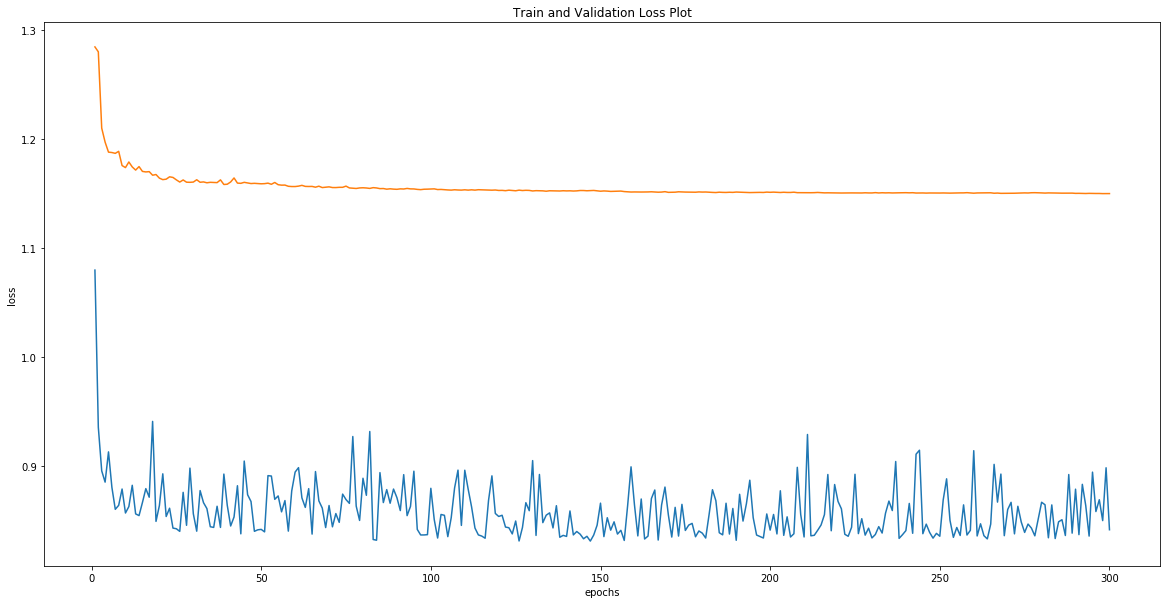

1 tensor(1.0797, grad_fn=<MeanBackward0>)


In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(range(1,epochs+1), train_mean_losses)
plt.plot(range(1,epochs+1), valid_mean_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Loss Plot')
plt.show()
max_y = max(train_mean_losses)  # Find the maximum y value
max_x = range(1,epochs+1)[train_mean_losses.index(max_y)]  # Find the x value corresponding to the maximum y value
print(max_x, max_y)

In [12]:
net.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [20]:
from sklearn.metrics import mean_squared_error
test_pred = np.empty((0,1))
with torch.no_grad():
    for iteration, batch_data in enumerate(test_loader):
        X_batch, y_batch = batch_data        
        out = net(X_batch)
        
        test_pred = np.append(test_pred, 
                                     out.numpy(), axis=0)
        
test_pred = np.array(test_pred)
test_pred = scaler_y.inverse_transform(test_pred)

test_gt = scaler_y.inverse_transform(test_y)

mse = mean_squared_error(test_gt, test_pred)
print(mse)

89926839.47308715
